In [1]:

import sys
# CPU-only build (fastest to get started, works everywhere)
!{sys.executable} -m pip install torch --index-url https://download.pytorch.org/whl/cpu


Looking in indexes: https://download.pytorch.org/whl/cpu


In [2]:
import sys
!{sys.executable} -m pip install yfinance


In [3]:
import numpy as np
import pandas as pd
import yfinance as yf
import matplotlib.pyplot as plt

import torch
import torch.nn as nn
import torch.optim as optim

from sklearn.preprocessing import StandardScaler
from sklearn.metrics import root_mean_squared_error

In [4]:
device = torch.device('cpu')

In [5]:
ticker = 'AAPL'
df = yf.download(ticker, '2020-01-01')
display(df.head(10))

[*********************100%***********************]  1 of 1 completed


Price,Close,High,Low,Open,Volume
Ticker,AAPL,AAPL,AAPL,AAPL,AAPL
Date,,,,,
2020-01-02,72.468262,72.528582,71.223259,71.476600,135480400
2020-01-03,71.763718,72.523746,71.539330,71.696160,146322800
2020-01-06,72.335548,72.374154,70.634532,70.885464,118387200
2020-01-07,71.995377,72.600983,71.775811,72.345227,108872000
2020-01-08,73.153496,73.455095,71.698581,71.698581,132079200
2020-01-09,74.707336,74.900357,73.879750,74.130675,170108400
2020-01-10,74.876221,75.440821,74.374363,74.941371,140644800
2020-01-13,76.475922,76.502466,75.074089,75.192321,121532000


<Axes: xlabel='Date'>

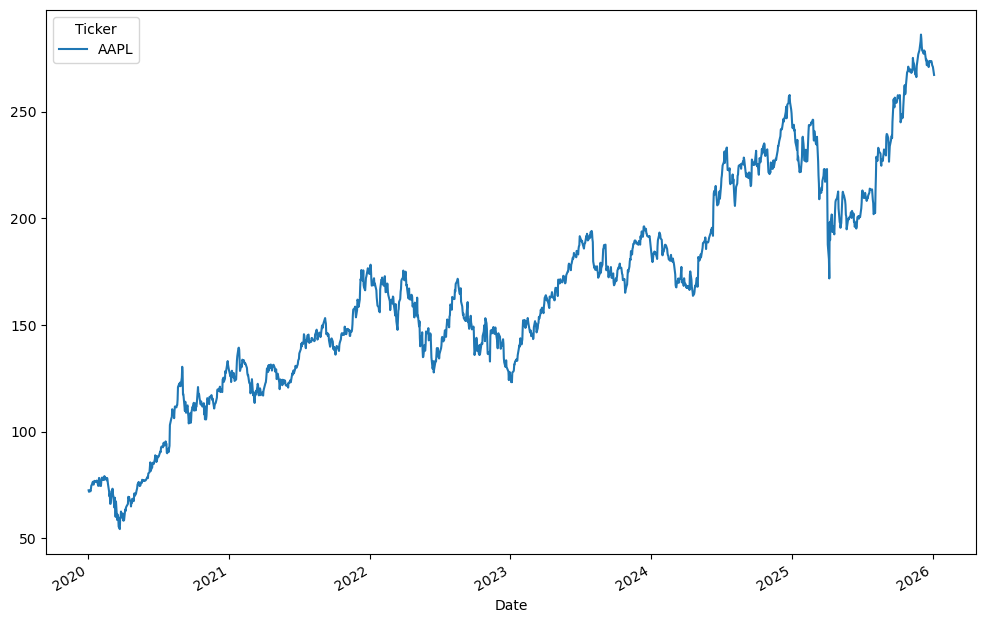

In [6]:
df.Close.plot(figsize = (12, 8))

In [7]:
scaler = StandardScaler()
# scale the closing data for our model to a normal distribution around 1
df['Close'] = scaler.fit_transform(df['Close']) 

In [8]:
df['Close'].head()

Ticker,AAPL
Date,
2020-01-02,-1.859157
2020-01-03,-1.873301
2020-01-06,-1.861821
2020-01-07,-1.868650
2020-01-08,-1.845401


In [9]:
#clarify the data for our neural network
#give a data range so our model can predict the closing price for the next day
seq_length = 31
data = []
for i in range(len(df) - seq_length): 
    # evaluate along the model in 30-day blocks
    #attempting to predict the value of the 31st day
    data.append(df.Close[i:i + seq_length])
data = np.array(data)


In [10]:
train_size = int(0.8*len(data))

X_train = torch.from_numpy(data[:train_size, :-1 :]).type(torch.Tensor).to(device)
Y_train = torch.from_numpy(data[:train_size, -1]).type(torch.Tensor).to(device)
X_test = torch.from_numpy(data[train_size:, :-1 :]).type(torch.Tensor).to(device)
Y_test = torch.from_numpy(data[train_size:, -1]).type(torch.Tensor).to(device)

In [11]:
class PredictionModel(nn.Module): #creating our model for predicition

    def __init__ (self, input_dim, hidden_dim, num_layers, output_dim):
        super(PredictionModel, self).__init__()

        self.num_layers = num_layers #number of stacked lstm layers
        self.hidden_dim = hidden_dim #hidden size of each lstm layer

        
         # Define the LSTM:
        # - input_dim: number of features per time step
        # - hidden_dim: hidden units in the LSTM
        # - num_layers: how many LSTM layers stacked
        # - batch_first=True: expects input shape (batch, seq_len, input_dim

        self.lstm = nn.LSTM(input_dim, hidden_dim, num_layers, batch_first= True)
        #fully connected layer mapping from hidden dimensions to the output
        self.fc = nn.Linear(hidden_dim, output_dim) 

    def forward(self, x): #forward passes through the model

        #initial version of hidden state and cell state
        h0 = torch.zeros(self.num_layers, x.size(0), self.hidden_dim, device = device)
        c0 = torch.zeros(self.num_layers, x.size(0), self.hidden_dim, device = device)


        #hn and cn are the final hidden and cell states with shapes
        out, (hn, cn) = self.lstm(x, (h0.detach(), c0.detach()))
        out = self.fc(out[:, -1, :])

        return out



        
    

In [12]:
model = PredictionModel(input_dim = 1, hidden_dim = 32, num_layers = 2, output_dim = 1).to(device)

In [13]:
criterion = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr = 0.01)

In [14]:
num_epochs = 250

for i in range(num_epochs):
    Y_train_pred = model(X_train)

    
    loss = criterion(Y_train_pred, Y_train) #measure performance

    if i % 25 == 0:
        print(i, loss.item()) #print loss to see model progress

    optimizer.zero_grad()#clear old gradient
    loss.backward() #back propagate to compute new gradient 
    optimizer.step() #update parameters using the gradient

0 0.6463091373443604
25 0.012170752510428429
50 0.005102318711578846
75 0.0045894356444478035
100 0.004295271821320057
125 0.004049136769026518
150 0.0038249711506068707
175 0.003620214993134141
200 0.0034356056712567806
225 0.0032726540230214596


In [15]:
model.eval()
Y_test_pred = model(X_test)

Y_train_pred = scaler.inverse_transform(Y_train_pred.detach().cpu().numpy())
Y_train = scaler.inverse_transform(Y_train.detach().cpu().numpy())
Y_test_pred = scaler.inverse_transform(Y_test_pred.detach().cpu().numpy())
Y_test = scaler.inverse_transform(Y_test.detach().cpu().numpy())



In [ ]:
train_rmse = root_mean_squared_error(Y_train[:, 0], Y_train_pred[:, 0])
test_rmse = root_mean_squared_error(Y_test[:, 0], Y_test_pred[:, 0])

In [33]:
train_rmse

2.7951982

In [35]:
test_rmse

7.39647